# <center> Predicting Zebrafish Movements in Virtual Reality

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from IPython.display import display
import functions
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_squared_error

##### The goal of this notebook is to model the egocentric visual field of the fish, that is, what the fish “sees” at each moment. Also we want to represent this perception in a structured, analyzable way.

##### We implement a polar pixel encoding, where each frame is transformed into a grid describing the spatial distribution of visual stimuli around the fish. From this encoding, we extract behaviorally meaningful features (such as stimulus density, spatial balance, or angular entropy).

##### These features are then used as input to a Random Forest to determine which aspects of the visual input are most influential for the fish’s decision-making (e.g., movement direction or change in orientation).

##### Ultimately, this approach aims to bridge perception and action by quantifying how visual stimuli shape behavioral responses in a controlled environment.

## <center> Exploring dataset and preprocessing

In [2]:
df = pd.read_csv('preprocessed_data.csv')
df = df.dropna()             # ------------    ONLY FOR SPEED DELETE THIS LINE LATER ------ THIS NOTEBOOK TAKE TOO MUCH TIME TO RUN WITH FULL DATA FOR NOW-------------------
df = df.head(50000)        # ------------    ONLY FOR SPEED DELETE THIS LINE LATER ---------------------------
df.head(-10)

f0_x   f0_y  f0_ori   f1_x   f1_y  f1_ori   f2_x   f2_y  f2_ori  \
850    166.0  116.0   5.397  226.0  167.0   5.830  231.0  271.0   5.792   
851    166.0  116.0   5.424  226.0  167.0   5.844  231.0  271.0   5.775   
852    166.0  116.0   5.371  226.0  167.0   5.807  231.0  271.0   5.805   
853    167.0  116.0   5.430  226.0  167.0   5.770  231.0  271.0   5.752   
854    167.0  116.0   5.377  226.0  167.0   5.820  232.0  271.0   5.803   
...      ...    ...     ...    ...    ...     ...    ...    ...     ...   
50835  168.0  159.0   5.585  187.0  164.0   6.087  213.0  221.0   4.534   
50836  169.0  158.0   5.595  187.0  164.0   6.107  213.0  221.0   4.541   
50837  170.0  158.0   5.553  187.0  164.0   6.093  213.0  220.0   4.536   
50838  170.0  157.0   5.520  187.0  164.0   6.106  213.0  220.0   4.507   
50839  170.0  157.0   5.533  187.0  163.0   6.073  213.0  220.0   4.533   

        f3_x  ...  d5_x  d5_y  d5_stim  d6_x  d6_y  d6_stim  d7_x  d7_y  \
850    185.0  ...   180   180     none   180   180     none   180   180   
851    185.0  ...   180   180     none   180   180     none   180   180   
852    185.0  ...   180   180     none   180   180     none   180   180   
853    186.0  ...   180   180     none   180   180     none   180   180   
854    185.0  ...   180   180     none   180   180     none   180   180   
...      ...  ...   ...   ...      ...   ...   ...      ...   ...   ...   
50835  291.0  ...   180   180     none   180   180     none   180   180   
50836  291.0  ...   180   180     none   180   180     none   180   180   
50837  291.0  ...   180   180     none   180   180     none   180   180   
50838  291.0  ...   180   180     none   180   180     none   180   180   
50839  291.0  ...   180   180     none   180   180     none   180   180   

       d7_stim         condition  
850       none  inter_stim_pause  
851       none  inter_stim_pause  
852       none  inter_stim_pause  
853       none  inter_stim_pause  
854       none  inter_stim_pause  
...        ...               ...  
50835     none  inter_stim_pause  
50836     none  inter_stim_pause  
50837     none  inter_stim_pause  
50838     none  inter_stim_pause  
50839     none  inter_stim_pause  

[49990 rows x 70 columns]

Quick stimulus description :

> The max distance between fish and stimulus is approximately 378 mm.

> When there is no stimulus k, dk_stim = 'none' and dk_x = dk_y = 180.


In [3]:
def check_unique_values(df):
    """Display numbre of possible values for each features with object type."""
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        unique_vals = df[col].nunique()
        print(f"{col}: {unique_vals} unique values")
        if unique_vals <= 10:
            print(" →", df[col].unique())
        print("-" * 40)
        
check_unique_values(df)

d0_stim: 16 unique values
----------------------------------------
d1_stim: 13 unique values
----------------------------------------
d2_stim: 11 unique values
----------------------------------------
d3_stim: 11 unique values
----------------------------------------
d4_stim: 7 unique values
 → ['none' 'CLsemi1800_g8-0_s3.5-3.5' 'CLsemi1800_g8-0_s0-0'
 'CLsemi1800_g6-0_s3.5-3.5' 'CLsemi1800_g0-8_s0-0'
 'CLsemi1800_g0-8_s3.5-3.5' 'CLsemi1800_g0-6_s3.5-3.5']
----------------------------------------
d5_stim: 7 unique values
 → ['none' 'CLsemi1800_g8-0_s3.5-3.5' 'CLsemi1800_g8-0_s0-0'
 'CLsemi1800_g6-0_s3.5-3.5' 'CLsemi1800_g0-8_s0-0'
 'CLsemi1800_g0-8_s3.5-3.5' 'CLsemi1800_g0-6_s3.5-3.5']
----------------------------------------
d6_stim: 5 unique values
 → ['none' 'CLsemi1800_g8-0_s3.5-3.5' 'CLsemi1800_g8-0_s0-0'
 'CLsemi1800_g0-8_s0-0' 'CLsemi1800_g0-8_s3.5-3.5']
----------------------------------------
d7_stim: 5 unique values
 → ['none' 'CLsemi1800_g8-0_s3.5-3.5' 'CLsemi1800_g8-0_s0-0'

##### There is a non sens to give conditional experiment information to the model. We want to give the present and past full state position of the fish and its visual field.

In [4]:
df = df.drop(columns=['condition'])

# transform dk_stim for each stimulus k into 0 if the feature is 'none' else 1.
for k in range(8):
    df[f'd{k}_stim'] = df[f'd{k}_stim'].apply(lambda x: 0 if x == 'none' else 1)    

In [5]:
df, _ = functions.remove_nan_plus_constant_and_correlated_features(df, corr_threshold=1.0)

The dataset contains : 0.0% of NaN.
There are few NaN, therefore we make the choice to remove them.
✅ No constant features found.
✅ No highly correlated features found.


##### In the actual dataset, each fish has its own set of columns (f0_x, f1_x, etc.).
##### However, since our goal is to predict the next position of a single fish, and because each fish behaves independently of the others in this experimental setup, it doesn’t make sense to include information from other fish as model inputs.

##### We therefore restructure the data so that each row corresponds to one fish at one time frame, with shared context variables (stimuli, condition, etc.) still available.
##### This makes the data more consistent with our modeling goal, learning the movement dynamics of individual fish, not group interactions.

In [6]:
fish_cols = [c for c in df.columns if c.startswith('f') and any(x in c for x in ['_x', '_y', '_ori'])]
df = functions.reshape_repeated_columns(df)
df = df.drop(columns=['fish_id']) # Make no sens to keep fish_id for prediction
df = df.drop(columns=['frame']) # Make no sens to keep frame for prediction
df.head()

✅ Reshape complete: 50000 frames × 15 fish → 750000 rows
Columns: ['f_x', 'f_y', 'f_ori', 'd0_x', 'd0_y', 'd0_stim', 'd1_x', 'd1_y', 'd1_stim', 'd2_x'] ...


f_x    f_y  f_ori  d0_x  d0_y  d0_stim  d1_x  d1_y  d1_stim  d2_x  ...  \
0  166.0  116.0  5.397   180   180        0   180   180        0   180  ...   
1  166.0  116.0  5.424   180   180        0   180   180        0   180  ...   
2  166.0  116.0  5.371   180   180        0   180   180        0   180  ...   
3  167.0  116.0  5.430   180   180        0   180   180        0   180  ...   
4  167.0  116.0  5.377   180   180        0   180   180        0   180  ...   

   d4_stim  d5_x  d5_y  d5_stim  d6_x  d6_y  d6_stim  d7_x  d7_y  d7_stim  
0        0   180   180        0   180   180        0   180   180        0  
1        0   180   180        0   180   180        0   180   180        0  
2        0   180   180        0   180   180        0   180   180        0  
3        0   180   180        0   180   180        0   180   180        0  
4        0   180   180        0   180   180        0   180   180        0  

[5 rows x 27 columns]

In [7]:
df = functions.compute_d_orientation(df)
df = functions.compute_speed(df)

df.head()

f_speed  d_ori    f_x    f_y  f_ori  d0_x  d0_y  d0_stim  d1_x  d1_y  ...  \
0      NaN  0.000  166.0  116.0  5.397   180   180        0   180   180  ...   
1      0.0  0.027  166.0  116.0  5.424   180   180        0   180   180  ...   
2      0.0 -0.053  166.0  116.0  5.371   180   180        0   180   180  ...   
3      1.0  0.059  167.0  116.0  5.430   180   180        0   180   180  ...   
4      0.0 -0.053  167.0  116.0  5.377   180   180        0   180   180  ...   

   d4_stim  d5_x  d5_y  d5_stim  d6_x  d6_y  d6_stim  d7_x  d7_y  d7_stim  
0        0   180   180        0   180   180        0   180   180        0  
1        0   180   180        0   180   180        0   180   180        0  
2        0   180   180        0   180   180        0   180   180        0  
3        0   180   180        0   180   180        0   180   180        0  
4        0   180   180        0   180   180        0   180   180        0  

[5 rows x 29 columns]

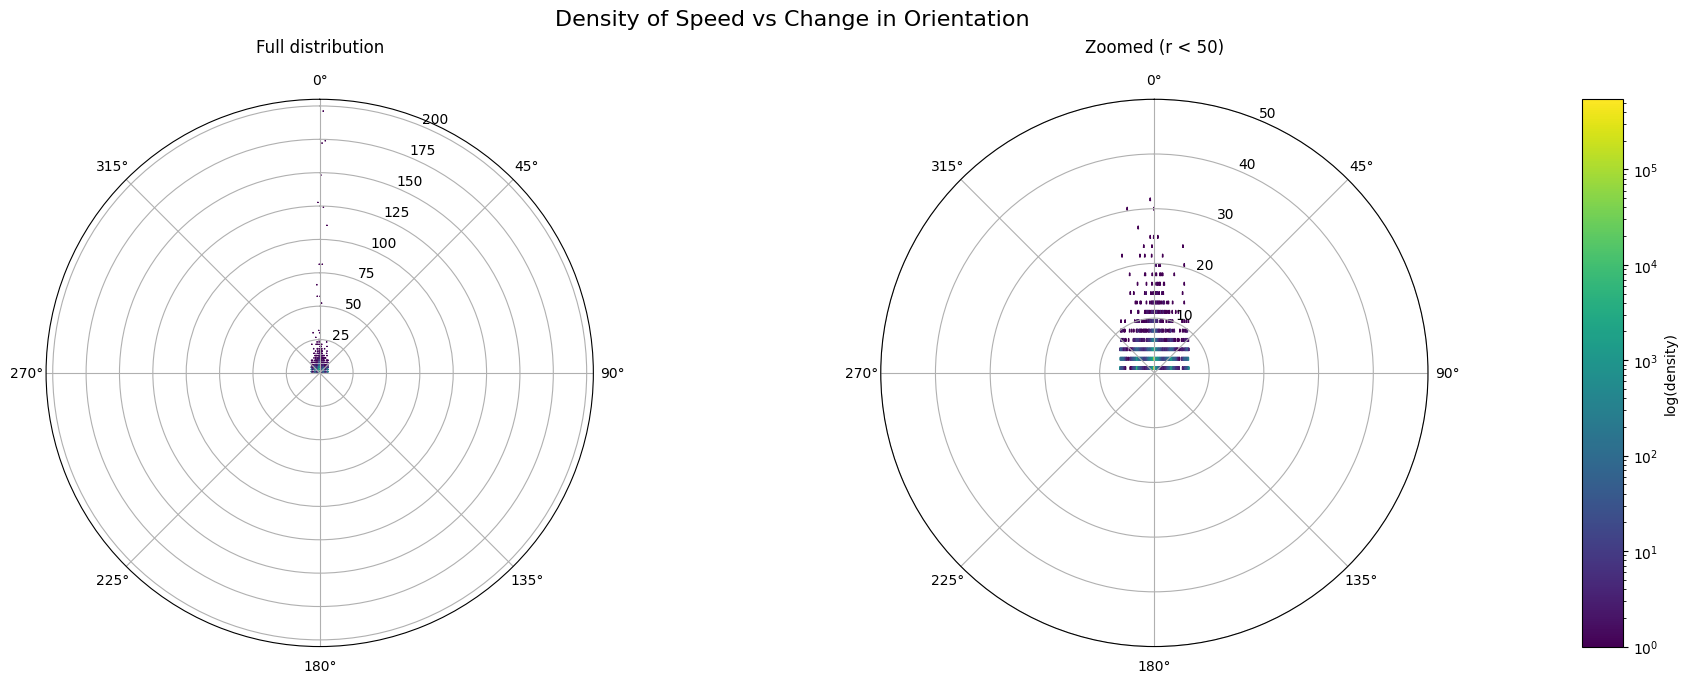

In [8]:
# Convert to polar coordinates (r = speed, θ = change in orientation)
r = df["f_speed"]
theta = df["d_ori"]

# --- Create figure layout ---
fig = plt.figure(figsize=(18, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])  # full plot | zoomed plot | colorbar

# Shared normalization (so both plots use same color range)
vmin, vmax = 1, 1000
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# --- 📊 (1) Full plot (identical to your original one) ---
ax1 = fig.add_subplot(gs[0, 0], polar=True)
ax1.set_theta_zero_location("N")
ax1.set_theta_direction(-1)
hb1 = ax1.hexbin(theta, r, gridsize=100, cmap="viridis", bins='log')
ax1.set_title("Full distribution", pad=15)

# --- 🔍 (2) Zoomed plot ---
ax2 = fig.add_subplot(gs[0, 1], polar=True)
ax2.set_theta_zero_location("N")
ax2.set_theta_direction(-1)
hb2 = ax2.hexbin(theta, r, gridsize=100, cmap="viridis", bins='log')
ax2.set_rmax(50)  # zoom on low speeds
ax2.set_title("Zoomed (r < 50)", pad=15)

# --- 🎨 (3) Separate colorbar ---
cax = fig.add_subplot(gs[0, 2])
cb = fig.colorbar(hb1, cax=cax)
cb.set_label("log(density)")

plt.suptitle("Density of Speed vs Change in Orientation", fontsize=16, y=0.97)
plt.tight_layout()
plt.show()

### Interpreting the Polar Density Plot

This plot shows the **distribution of fish movements** in **polar coordinates**, where:

- **r (radius)** = the *speed* of the fish (the magnitude of its displacement between frames).  
- **θ (angle)** = the *change in orientation* (Δorientation, in radians) between consecutive frames.

Each hexagonal bin represents how frequently a given combination of speed and turning angle occurs:
- Points near **θ = 0** correspond to **straight motion** (no turning).  
- Points near **|θ| = π/2** or **π** correspond to **sharp turns or reversals**.  
- The **color intensity** encodes how often those motions occur (darker = more frequent).

As the points near θ = 0, we will simply use orientation in radian rather making more trigonometric computations.

_

Since the dataset represents **time series** rather than independent samples, each observation depends on the fish’s recent past.  
To make the model aware of temporal dependencies, we include **lag features** the positions and orientations from the last few frames.

Formally, we build the following features:

$$
\text{Input: } \{f_x(t - 1), \ldots, f_x(t - 60), \; f_y(t - 1), \ldots, f_y(t - 60), \; f_{\text{ori}}(t - 1), \ldots, f_{\text{ori}}(t - 60)\}
$$

$$
\text{Target: } \{ f_x(t + 3), \; f_y(t + 3), \; f_{\text{ori}}(t +3) \}
$$

This way, the model learns motion dynamics, how past positions and orientations lead to the next movement — instead of treating each frame as an isolated event.

In [9]:
# Parameters
n_lags = 60          # ~1.5s at 30 FPS
subsample = 3        
cols_to_lag = ['f_speed', 'd_ori']

# Create lag features with subsampling
for col in cols_to_lag:
    for lag in range(subsample, n_lags + 1, subsample):
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

print(f"✅ Created lag features for {cols_to_lag} with subsampling every {subsample} frames "
      f"(covering {n_lags / 30:.2f} seconds at 30 FPS).")

✅ Created lag features for ['f_speed', 'd_ori'] with subsampling every 3 frames (covering 2.00 seconds at 30 FPS).


##### The dataset was recorded at 30 frames per second, meaning that 15 frames correspond to roughly 0.5 seconds.
##### Based on the experiment description, fish approximately make a new movement decision about once per second (each “bout”).
##### Setting delta_t = 3 therefore allows us to predict a fish’s state halfway between two typical bouts, far enough to capture meaningful motion, but close enough to remain within a single behavioral context.

In [10]:
delta_t = 15

# Target = 15 frames ahead
df['f_speed_next'] = df['f_speed'].shift(-delta_t)
df['d_ori_next'] = df['d_ori'].shift(-delta_t)

# Drop NaN rows created by shifting
df = df.dropna(subset=[f'f_speed_lag_{n_lags}', 'f_speed_next'])

df.head()

f_speed  d_ori    f_x    f_y  f_ori  d0_x  d0_y  d0_stim  d1_x  d1_y  ...  \
61      0.0 -0.053  173.0  109.0  5.338   180   180        0   180   180  ...   
62      0.0  0.000  173.0  109.0  5.338   180   180        0   180   180  ...   
63      0.0  0.052  173.0  109.0  5.390   180   180        0   180   180  ...   
64      0.0 -0.044  173.0  109.0  5.346   180   180        0   180   180  ...   
65      0.0  0.015  173.0  109.0  5.361   180   180        0   180   180  ...   

    d_ori_lag_39  d_ori_lag_42  d_ori_lag_45  d_ori_lag_48  d_ori_lag_51  \
61         0.000         0.005        -0.040         0.041         0.015   
62         0.016        -0.006         0.001        -0.203        -0.041   
63        -0.002        -0.005        -0.048         0.136         0.098   
64        -0.043         0.000         0.005        -0.040         0.041   
65         0.034         0.016        -0.006         0.001        -0.203   

    d_ori_lag_54  d_ori_lag_57  d_ori_lag_60  f_speed_next  d_ori_next  
61        -0.102        -0.053         0.027           0.0       0.056  
62         0.107         0.036        -0.053           0.0      -0.050  
63        -0.026         0.021         0.059           0.0      -0.017  
64         0.015        -0.102        -0.053           0.0      -0.015  
65        -0.041         0.107         0.036           0.0       0.046  

[5 rows x 71 columns]

In [11]:
df.head()

f_speed  d_ori    f_x    f_y  f_ori  d0_x  d0_y  d0_stim  d1_x  d1_y  ...  \
61      0.0 -0.053  173.0  109.0  5.338   180   180        0   180   180  ...   
62      0.0  0.000  173.0  109.0  5.338   180   180        0   180   180  ...   
63      0.0  0.052  173.0  109.0  5.390   180   180        0   180   180  ...   
64      0.0 -0.044  173.0  109.0  5.346   180   180        0   180   180  ...   
65      0.0  0.015  173.0  109.0  5.361   180   180        0   180   180  ...   

    d_ori_lag_39  d_ori_lag_42  d_ori_lag_45  d_ori_lag_48  d_ori_lag_51  \
61         0.000         0.005        -0.040         0.041         0.015   
62         0.016        -0.006         0.001        -0.203        -0.041   
63        -0.002        -0.005        -0.048         0.136         0.098   
64        -0.043         0.000         0.005        -0.040         0.041   
65         0.034         0.016        -0.006         0.001        -0.203   

    d_ori_lag_54  d_ori_lag_57  d_ori_lag_60  f_speed_next  d_ori_next  
61        -0.102        -0.053         0.027           0.0       0.056  
62         0.107         0.036        -0.053           0.0      -0.050  
63        -0.026         0.021         0.059           0.0      -0.017  
64         0.015        -0.102        -0.053           0.0      -0.015  
65        -0.041         0.107         0.036           0.0       0.046  

[5 rows x 71 columns]

In [12]:
df.columns

Index(['f_speed', 'd_ori', 'f_x', 'f_y', 'f_ori', 'd0_x', 'd0_y', 'd0_stim',
       'd1_x', 'd1_y', 'd1_stim', 'd2_x', 'd2_y', 'd2_stim', 'd3_x', 'd3_y',
       'd3_stim', 'd4_x', 'd4_y', 'd4_stim', 'd5_x', 'd5_y', 'd5_stim', 'd6_x',
       'd6_y', 'd6_stim', 'd7_x', 'd7_y', 'd7_stim', 'f_speed_lag_3',
       'f_speed_lag_6', 'f_speed_lag_9', 'f_speed_lag_12', 'f_speed_lag_15',
       'f_speed_lag_18', 'f_speed_lag_21', 'f_speed_lag_24', 'f_speed_lag_27',
       'f_speed_lag_30', 'f_speed_lag_33', 'f_speed_lag_36', 'f_speed_lag_39',
       'f_speed_lag_42', 'f_speed_lag_45', 'f_speed_lag_48', 'f_speed_lag_51',
       'f_speed_lag_54', 'f_speed_lag_57', 'f_speed_lag_60', 'd_ori_lag_3',
       'd_ori_lag_6', 'd_ori_lag_9', 'd_ori_lag_12', 'd_ori_lag_15',
       'd_ori_lag_18', 'd_ori_lag_21', 'd_ori_lag_24', 'd_ori_lag_27',
       'd_ori_lag_30', 'd_ori_lag_33', 'd_ori_lag_36', 'd_ori_lag_39',
       'd_ori_lag_42', 'd_ori_lag_45', 'd_ori_lag_48', 'd_ori_lag_51',
       'd_ori_lag_54', '

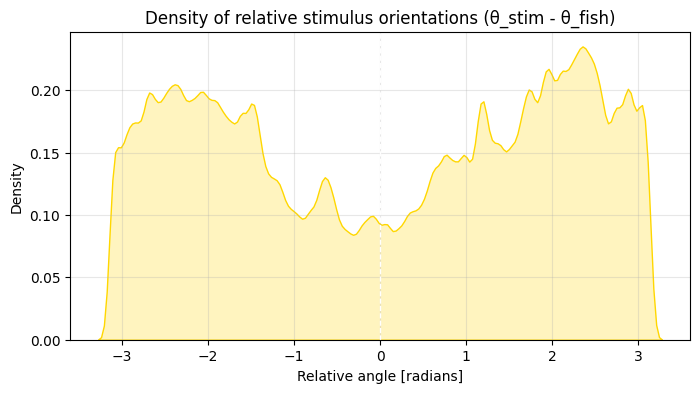

In [13]:
# On stocke tous les angles relatifs ici
relative_angles = []

# Parcours de chaque ligne du DataFrame
for _, row in df.iterrows():
    fish_ori = row["f_ori"]
    
    for k in range(8):  # d0 à d7
        stim_col = f"d{k}_stim"
        if stim_col in row and row[stim_col] == "none":
            continue  # ignorer les absents

        x = row[f"d{k}_x"]
        y = row[f"d{k}_y"]
        
        # --- Convert to egocentric coordinates ---
        dx = x - row["f_x"]
        dy = y - row["f_y"]

        # Calcul de l'angle absolu du stimulus par rapport à l'horizontale
        stim_angle = np.arctan2(dy, dx)

        # Orientation relative au poisson
        rel_angle = stim_angle - fish_ori
        
        # Mise dans l'intervalle [-π, π]
        rel_angle = (rel_angle + np.pi) % (2 * np.pi) - np.pi
        
        relative_angles.append(rel_angle)

# --- Visualisation ---
plt.figure(figsize=(8, 4))
sns.kdeplot(relative_angles, fill=True, color="gold", bw_adjust=0.5)
plt.title("Density of relative stimulus orientations (θ_stim - θ_fish)")
plt.xlabel("Relative angle [radians]")
plt.ylabel("Density")
plt.axvline(0, color="white", ls="--", lw=1)
plt.grid(alpha=0.3)
plt.show()

In [14]:
dX_columns = [f'd{i}_{axis}' for i in range(8) for axis in ['x', 'y']]

# Compute polar encodings (keep stimulus columns for now)
df["polar_encoding"] = df.apply(functions.polar_pixel_encoding, axis=1)

# Optionally: drop the raw stimulus coordinates *after* encoding
df = df.drop(columns=dX_columns)

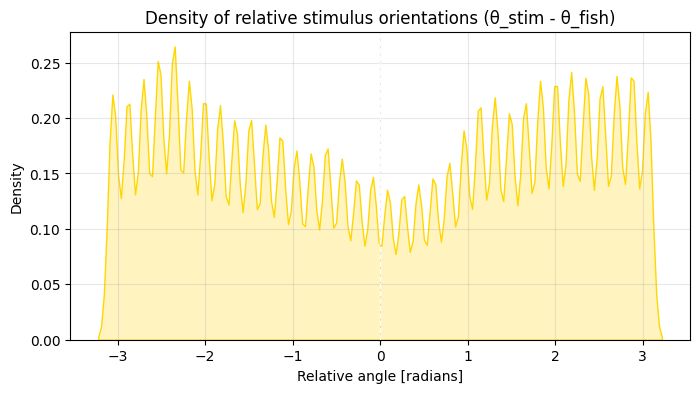

In [15]:
r_bins = 20
theta_bins = 36
theta_bin_edges = np.linspace(-np.pi, np.pi, theta_bins + 1)

all_thetas = []

for enc in df["polar_encoding"]:
    if isinstance(enc, np.ndarray):
        # Trouve les indices angulaires où il y a au moins un 1
        active_bins = np.argwhere(enc == 1)
        for r_idx, theta_idx in active_bins:
            # Convertit le bin d'angle en un angle réel (centre du bin)
            theta_center = (theta_bin_edges[theta_idx] + theta_bin_edges[theta_idx + 1]) / 2
            all_thetas.append(theta_center)

all_thetas = np.array(all_thetas)

# --- Visualisation ---
plt.figure(figsize=(8, 4))
sns.kdeplot(all_thetas, fill=True, color="gold", bw_adjust=0.5)
plt.title("Density of relative stimulus orientations (θ_stim - θ_fish)")
plt.xlabel("Relative angle [radians]")
plt.ylabel("Density")
plt.axvline(0, color="white", ls="--", lw=1)
plt.grid(alpha=0.3)
plt.show()

##### This density plot suggests the pixel encoding polar coordinates worked well.

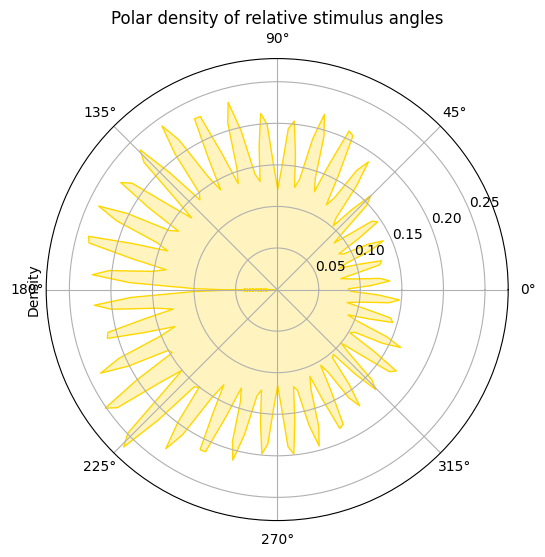

In [16]:
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
sns.kdeplot(all_thetas, fill=True, color="gold", bw_adjust=0.5, ax=ax)
ax.set_title("Polar density of relative stimulus angles")
plt.show()

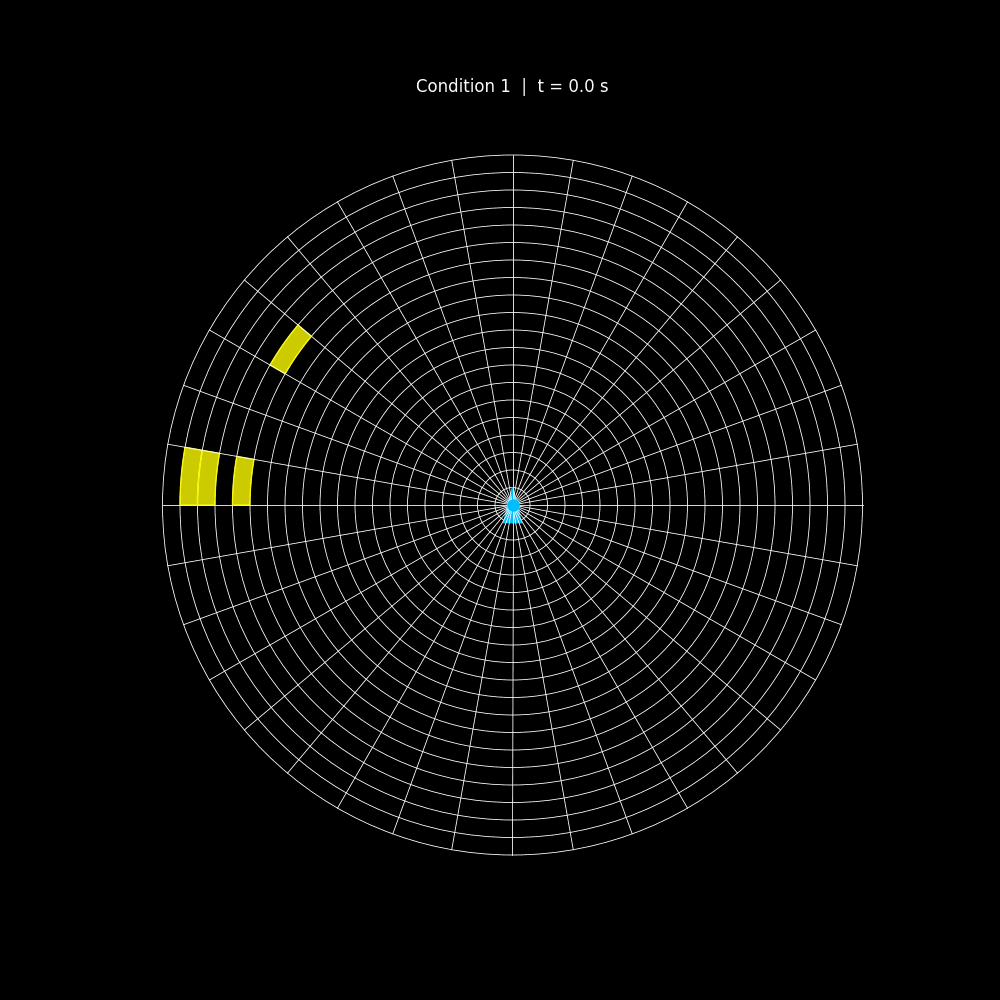

In [17]:
functions.make_polar_encoding_gif_segments(df, segment_starts=[1500,51000,147000])

### Animated visualization of fish visual field

##### The following GIF shows how the polar encoding evolves over time, with the fish facing **right (0 radians)**. It was created using make_polar_encoding_gif_segments in functions.py

![Polar encoding GIF](polar_segments.gif)

In [20]:
polar_features_df = df["polar_encoding"].apply(functions.extract_polar_features).apply(pd.Series)
df = pd.concat([df, polar_features_df], axis=1)


In [21]:
df=df.drop(columns=['polar_encoding'])

In [22]:
df.head()

f_speed  d_ori    f_x    f_y  f_ori  d0_stim  d1_stim  d2_stim  d3_stim  \
61      0.0 -0.053  173.0  109.0  5.338        0        0        0        0   
62      0.0  0.000  173.0  109.0  5.338        0        0        0        0   
63      0.0  0.052  173.0  109.0  5.390        0        0        0        0   
64      0.0 -0.044  173.0  109.0  5.346        0        0        0        0   
65      0.0  0.015  173.0  109.0  5.361        0        0        0        0   

    d4_stim  ...  stim_count  avg_radius  min_radius  front_ratio  \
61        0  ...         0.0         0.0        20.0          0.0   
62        0  ...         0.0         0.0        20.0          0.0   
63        0  ...         0.0         0.0        20.0          0.0   
64        0  ...         0.0         0.0        20.0          0.0   
65        0  ...         0.0         0.0        20.0          0.0   

    left_right_balance  angular_entropy  radial_entropy  center_of_mass_theta  \
61                 0.0             -0.0            -0.0                   0.0   
62                 0.0             -0.0            -0.0                   0.0   
63                 0.0             -0.0            -0.0                   0.0   
64                 0.0             -0.0            -0.0                   0.0   
65                 0.0             -0.0            -0.0                   0.0   

    n_rings_active  n_angles_active  
61             0.0              0.0  
62             0.0              0.0  
63             0.0              0.0  
64             0.0              0.0  
65             0.0              0.0  

[5 rows x 65 columns]

In [ ]:
df=df.drop(columns=['f_x', 'f_y','f_ori'])

# <center> Random Forest


 Training RF for target = f_speed_next  |  dataset = All features
✅ Done — R²: 0.118 | RMSE: 1.029

 Training RF for target = f_speed_next  |  dataset = Polar + target only


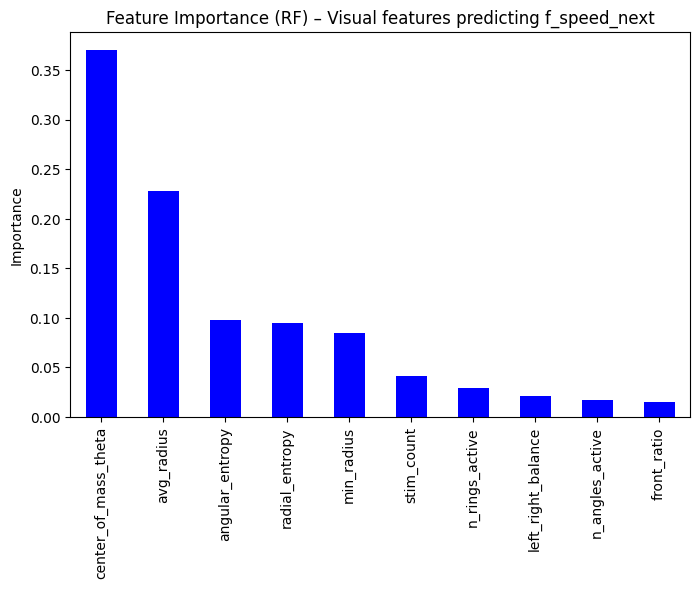

✅ Done — R²: -0.042 | RMSE: 1.118

 Training RF for target = d_ori_next  |  dataset = All features


KeyboardInterrupt: 

In [23]:
# --- Targets et datasets à comparer ---
targets = ["f_speed_next", "d_ori_next"]

# --- Résultats stockés ici ---
results = []

# --- Boucle principale ---
for target in targets:
    target_cols = [target]

    # Datasets adaptés à la target courante
    datasets = {
        "All features": df,
        "Polar + target only": pd.concat([df[[target]], polar_features_df], axis=1)
    }

    for name, data in datasets.items():
        print(f"\n Training RF for target = {target}  |  dataset = {name}")

        # Split temporel
        X_train, X_val, X_test, y_train, y_val, y_test = functions.temporal_train_val_test_split(
            data,
            target_cols=target_cols,
            train_size=0.7,
            val_size=0.15,
            verbose=False
        )

        # Random Forest
        rf = RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)

        # Performance sur test set
        y_pred = rf.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results.append({
            "target": target,
            "dataset": name,
            "R²": round(r2, 3),
            "RMSE": round(rmse, 3)
        })

        # Plot d’importance uniquement pour les features visuelles
        if name == "Polar + target only":
            importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
            plt.figure(figsize=(8, 5))
            importances.plot(kind='bar', color='blue')
            plt.title(f"Feature Importance (RF) – Visual features predicting {target}")
            plt.ylabel("Importance")
            plt.show()

        print(f"✅ Done — R²: {r2:.3f} | RMSE: {rmse:.3f}")

# --- Résumé global ---
results_df = pd.DataFrame(results)
display(results_df)

#### This last cell took too much time too run so I interrupted